In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
import matplotlib.pyplot as plt

# RESNET

In [2]:
#Creiamo un tf.data.Dataset a partire dalle immagini nella directory su disco per il training set e il test set.
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    labels='inferred',
    label_mode='int'
)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    'test',
    labels='inferred',
    label_mode='int'
)

Found 16932 files belonging to 4 classes.
Found 4233 files belonging to 4 classes.


In [3]:
#image_batch è un tensore della forma (32, 256, 256, 3).
#Questo è un batch di 32 immagini di forma 256x256x3. 
#Il label_batch è un tensore della forma (32,4) cioè in ogni batch ci sono 32 immagini e le etichette sono 4.
for image_batch, labels_batch in train_set:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


In [7]:
#Ogni elemento del train_set è un tensore con shape (32, 256, 256, 3) cioè è un insieme di 32 immagini
#di dimensione 256x256x3 dove i valori dei pixel sono di tipo float32.
for i in train_set:
    print(i)
    break

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 68.96682  ,  68.96682  ,  68.96682  ],
         [ 15.593117 ,  15.593117 ,  15.593117 ],
         [  6.441185 ,   6.441185 ,   6.441185 ],
         ...,
         [  1.       ,   1.       ,   1.       ],
         [  1.       ,   1.       ,   1.       ],
         [  1.       ,   1.       ,   1.       ]],

        [[ 10.789402 ,  10.789402 ,  10.789402 ],
         [  8.6230545,   8.6230545,   8.6230545],
         [  8.566074 ,   8.566074 ,   8.566074 ],
         ...,
         [  1.       ,   1.       ,   1.       ],
         [  1.       ,   1.       ,   1.       ],
         [  1.       ,   1.       ,   1.       ]],

        [[  4.847103 ,   4.847103 ,   4.847103 ],
         [  8.566074 ,   8.566074 ,   8.566074 ],
         [  9.       ,   9.       ,   9.       ],
         ...,
         [  1.       ,   1.       ,   1.       ],
         [  1.       ,   1.       ,   1.       ],
         [  1.       ,   1.       ,   1.    

Per poter usare ResNet50 occorre preprocessare le immagini in input in modo che siano di dimensione 224x224x3 e che siano convertite da RGB a BGR, così che ognuno dei tre canali sia centrato in zero.

In [10]:
#Eseguiamo il resize.
resize = tf.keras.Sequential(layers.experimental.preprocessing.Resizing(224, 224))

def prepare(ds):
    #Resize
    ds = ds.map(lambda x, y: (resize(x),y))
    return ds

train_set = prepare(train_set)
test_set = prepare(test_set)

In [11]:
#Verifichiamo che sia avvenuto il resize.
for image_batch, labels_batch in train_set:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [20]:
#Eseguiamo la conversione da RGB a BGR mediante la funzione preprocess_input offerta dal modulo resnet50.

#Train
for image_batch, labels_batch in train_set:
    for image in image_batch:
        image = preprocess_input(image, data_format=None)
        
#Test
for image_batch, labels_batch in test_set:
    for image in image_batch:
        image = preprocess_input(image, data_format=None)

# TRANSFER LEARNING

In [21]:
#Creiamo il modello base considerando la rete ResNet50 pre-addestrata su ImageNet.
#Non consideriamo gli ultimi layer che sono finalizzati agli obiettivi di classificazione di Imagenet.
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')

94773248/94765736 [==============================] - 155s 2us/step


In [22]:
#Il base_model si comporta quindi come un estrattore di featues,
#In particolare estrae dalle immagini 224x224x3 in blocchi 7x7x2048 di features. 
image_batch, label_batch = next(iter(train_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [23]:
#Congeliamo il resto dei layer impedendone così l'aggiornamento durante l'addestramento.
base_model.trainable = False

In [32]:
#Definiamo il modello, è necessario aggiungere al modello preaddestrato dei nuovi layer, utilizziamo un layer di tipo
#FLATTEN per favorire la connessione tra l'ultimo layer della rete preaddestrata e i nuovi layer. 
#Dopo di che aggiungiamo un layer di tipo DENSE per eseguire la classificazione tra le 4 classi che sono di
#nostro interesse.
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(4))

In [33]:
#Compiliamo il modello.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
#Addestriamo il modello sul train set.
history = model.fit(train_set, epochs=5)

Epoch 1/5
530/530 [==============================] - 2007s 4s/step - loss: 4.7800 - accuracy: 0.7860
Epoch 2/5
530/530 [==============================] - 2004s 4s/step - loss: 1.4218 - accuracy: 0.9247
Epoch 3/5
530/530 [==============================] - 1995s 4s/step - loss: 1.1089 - accuracy: 0.9404
Epoch 4/5
530/530 [==============================] - 1784s 3s/step - loss: 0.8590 - accuracy: 0.9564
Epoch 5/5
530/530 [==============================] - 1670s 3s/step - loss: 0.5351 - accuracy: 0.9684


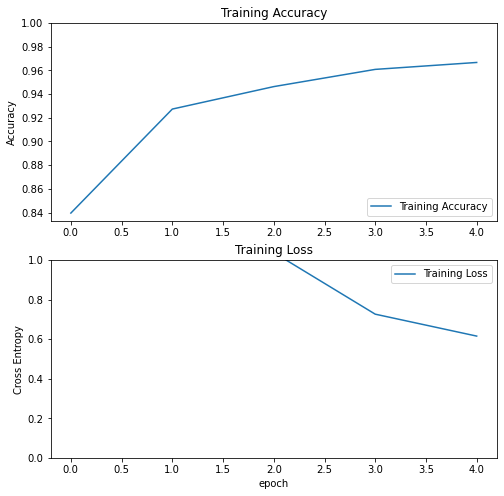

In [35]:
import matplotlib.pyplot as plt
#Analizziamo l'andamento dell'addestramento.
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
#Valutiamo le prestazioni del modello sul test set.
loss_test, accuracy_test = model.evaluate(test_set)
print('Test accuracy :', accuracy_test)

133/133 [==============================] - 406s 3s/step - loss: 4.7597 - accuracy: 0.8750
Test accuracy : 0.8750295042991638


# FINE TUNING

Un modo per incrementare le performance è eseguire fine-tuning, dove nel processo di training si 'aggiustano' i pesi degli ultimi layers così da specializzare la rete ancor di più al nostro dataset.

In [37]:
#'Scongeliamo' il base_model in modo da non addestrare solo i layer più in basso.
base_model.trainable = True

num_layers = len(base_model.layers)
num_layers

175

In [38]:
#Scegliamo di addestrare il modello solo a partire dal centesimo layer in su.
#quindi congeliamo tutti i layer precedenti.
finetune = 100
for layer in base_model.layers[:finetune]:
    layer.trainable =  False

In [41]:
#Ricompiliamo il modello.
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = 'adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_2 (ModuleWrap (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 401412    
Total params: 23,989,124
Trainable params: 19,854,340
Non-trainable params: 4,134,784
_________________________________________________________________


In [44]:
#Continuiamo con l'addestramento.
finetune_epochs = 5
total_epochs =  5 + finetune_epochs

history_fine = model.fit(train_set, epochs=total_epochs, initial_epoch=history.epoch[-1])
acc += history_fine.history['accuracy']
loss += history_fine.history['loss']

Epoch 5/10
530/530 [==============================] - 3483s 7s/step - loss: 9.7237 - accuracy: 0.8138
Epoch 6/10
530/530 [==============================] - 3453s 7s/step - loss: 6.1128 - accuracy: 0.8459
Epoch 7/10
530/530 [==============================] - 3457s 7s/step - loss: 0.6845 - accuracy: 0.9212
Epoch 8/10
530/530 [==============================] - 3462s 7s/step - loss: 0.3350 - accuracy: 0.9522
Epoch 9/10
530/530 [==============================] - 3461s 7s/step - loss: 0.8228 - accuracy: 0.9392
Epoch 10/10
530/530 [==============================] - 3580s 7s/step - loss: 0.8161 - accuracy: 0.9511


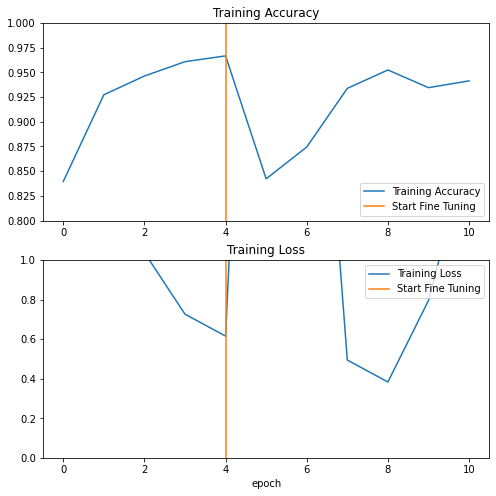

In [45]:
#Analizziamo l'andamento dell'addestramento.
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')

plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()


In [46]:
#Valutazione del modello sul test set.
loss_test, accuracy_test = model.evaluate(test_set)
print('Test accuracy :', accuracy_test)

133/133 [==============================] - 423s 3s/step - loss: 13.2546 - accuracy: 0.8098
Test accuracy : 0.8098275661468506
